# Linearly decoded VAE

This notebook shows how to use the 'linearly decoded VAE' model which explicitly links latent variables of cells to genes.

The scVI package learns low-dimensional latent representations of cells which get mapped to parameters of probability distributions which can generate counts consistent to what is observed from data. In the standard `VAE` model of scVI these parameters for each gene and cell arise from applying neural networks to the latent variables. Neural networks are flexible and can represent non-linearities in the data. This comes at a price, there is no direct link between a latent variable dimension and any potential set of genes which would covary across it.

The `LDVAE` model replaces the neural networks with linear functions. Now a higher value along a latent dimension will directly correspond to higher expression of the genes with high weights assigned to that dimension.

This leads to a generative model comparable to probabilistic PCA or factor analysis, but generates counts rather than real numbers. Using the framework of scVI also allows variational inference which scales to very large datasets and can make use of GPUs for additional speed.

This notebook demonstrates how to fit an `LDVAE` model to scRNA-seq data, plot the latent variables, and interpret which genes are linked to latent variables.

As an example, we use the PBMC 10K from 10x Genomics.

In [1]:
import sys

#if stable==True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

     |████████████████████████████████| 153kB 2.9MB/s 
     |████████████████████████████████| 122kB 8.1MB/s 
     |████████████████████████████████| 153kB 9.4MB/s 
     |████████████████████████████████| 112kB 13.8MB/s 
     |████████████████████████████████| 8.7MB 8.2MB/s 
     |████████████████████████████████| 2.4MB 48.8MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 3.2MB 42.4MB/s 
     |████████████████████████████████| 7.7MB 56.3MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 112kB 42.0MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 


In [2]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scvi

%matplotlib inline

## Initialization
Load data and select the top 1000 variable genes with seurat_v3 method

In [5]:
save_path = 'data'
adata = sc.read(os.path.join(save_path, "pbmc_10k_protein_v3.h5ad"), backup_url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true")

adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

sc.pp.highly_variable_genes(adata, flavor='seurat_v3', layer='counts', n_top_genes=1000, subset=True)

## Create and fit `LDVAE` model

First subsample 1,000 genes from the original data.

Then we initialize an `LinearSCVI` model. Here we set the latent space to have 10 dimensions.

In [6]:
# setup the anndata for scvi-tools
scvi.data.setup_anndata(adata, layer="counts")

INFO      No batch_key inputted, assuming all cells are same batch              
INFO      No label_key inputted, assuming all cells have same label             
INFO      Using data from adata.layers["counts"]                                
INFO      Computing library size prior per batch                                
INFO      Successfully registered anndata object containing 6855 cells, 1000    
          genes, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra   
          categorical covariates and 0 extra continuous covariates.             
INFO      Please do not further modify adata until model is trained.            


In [13]:
# initialize LinearSCVI model
model = scvi.model.LinearSCVI(adata, n_latent=10)

In [14]:
# train for 250 epochs, compute metrics every 10 epochs
model.train(n_epochs=250, lr = 5e-3, frequency = 10)

INFO      KL warmup phase exceeds overall training phaseIf your applications    
          rely on the posterior quality, consider training for more epochs or   
          reducing the kl warmup.                                               
INFO      KL warmup for 400 epochs                                              


Output()

INFO      Training is still in warming up phase. If your applications rely on   
          the posterior quality, consider training for more epochs or reducing  
          the kl warmup.                                                        
INFO      Training time:  610 s. / 250 epochs                                   


Inspecting the convergence

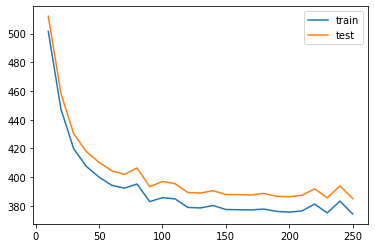

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))

#ignore plotting elbo of first epoch
train_elbo = model.trainer.history['elbo_train_set'][1:]
test_elbo = model.trainer.history['elbo_test_set'][1:]
epochs = np.arange(10,260,10)

ax.plot(epochs, train_elbo, label='train')
ax.plot(epochs, test_elbo, label='test')
ax.legend()

## Extract and plot latent dimensions for cells

From the fitted model we extract the (mean) values for the latent dimensions. We store the values in the AnnData object for convenience.

In [30]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f'Z_{i}'] = z

Now we can plot the latent dimension coordinates for each cell. A quick (albeit not complete) way to view these is to make a series of 2D scatter plots that cover all the dimensions. Since we are representing the cells by 10 dimensions, this leads to 5 scatter plots.

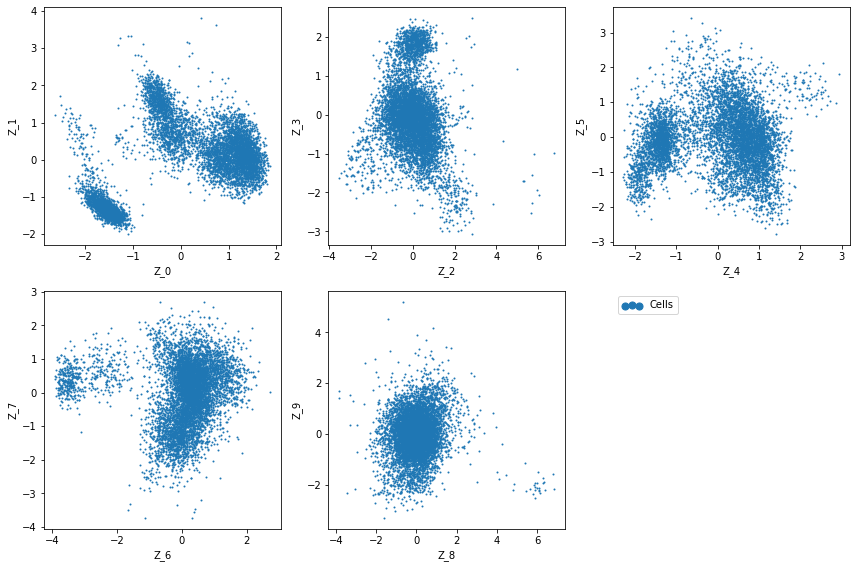

In [31]:
fig = plt.figure(figsize=(12, 8))

for f in range(0, 9, 2):
    plt.subplot(2, 3, int(f / 2) + 1)

    plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], marker='.', s=4, label='Cells')

    plt.xlabel(f'Z_{f}')
    plt.ylabel(f'Z_{f + 1}')

plt.subplot(2, 3, 6)    
plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], marker='.', label='Cells', s=4)
plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], c='w', label=None)
plt.gca().set_frame_on(False)
plt.gca().axis('off')

lgd = plt.legend(scatterpoints=3, loc='upper left')
for handle in lgd.legendHandles:
    handle.set_sizes([200])


plt.tight_layout()

The question now is how does the latent dimensions link to genes?

For a given cell x, the expression of the gene g is proportional to x_g = w_(1, g) * z_1 + ... + w_(10, g) * z_10. Moving from low values to high values in z_1 will mostly affect expression of genes with large w_(1, :) weights. We can extract these weights from the `LDVAE` model, and identify which genes have high weights for each latent dimension.

In [32]:
loadings = model.get_loadings()
loadings.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9
index,,,,,,,,,,
AL645608.8,0.324633,0.371819,-0.506400,-0.223466,0.892794,-0.159674,0.262996,0.153283,0.255206,-0.437038
HES4,0.163603,0.267337,-0.609207,-0.104167,0.714251,0.242553,0.286895,-0.319639,-0.199062,-0.327728
ISG15,0.843713,0.274809,-0.297248,0.151453,0.308765,0.052718,0.267909,-0.049191,0.235773,0.066666
TNFRSF18,1.476064,0.618349,0.090499,-0.287326,-0.570826,1.122171,1.001075,-0.128721,-0.145033,-0.289671
TNFRSF4,1.864890,0.357825,-0.020202,-0.209817,-0.101954,0.953238,1.105090,-0.165048,-0.160482,0.090853


For every latent variable Z, we extract the genes with largest _magnitude_, and separate genes with large negative values from genes with large positive values. We print out the top 5 genes in each direction for each latent variable.

In [33]:
print('Top loadings by magnitude\n---------------------------------------------------------------------------------------')
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ':\t'
    fstr += '\t'.join([f'{i}, {loading_[i]:.2}' for i in loading_.head(5).index])
    fstr += '\n\t...\n\t'
    fstr += '\t'.join([f'{i}, {loading_[i]:.2}' for i in loading_.tail(5).index])
    print(fstr + '\n---------------------------------------------------------------------------------------\n')

Top loadings by magnitude
---------------------------------------------------------------------------------------
Z_0:	ITGAX, -0.92	LYZ, -0.88	TYROBP, -0.86	CES1, -0.82	MS4A4A, -0.78
	...
	NELL2, 2.7	GP9, 2.7	MAL, 2.7	TRAV4, 2.9	IL7R, 2.9
---------------------------------------------------------------------------------------

Z_1:	IL1B, -1.9	LGALS2, -1.8	NRG1, -1.6	CYP27A1, -1.6	CXCL8, -1.5
	...
	AC004585.1, 1.1	RRM2, 1.1	C2ORF48, 1.3	LAIR2, 1.3	AC007240.1, 1.4
---------------------------------------------------------------------------------------

Z_2:	S100B, -1.7	C1QB, -1.4	C1QC, -1.4	C1QA, -1.3	PKIB, -1.1
	...
	IGHG3, 0.96	IGLV3-1, 1.0	IGHG2, 1.1	IGLV6-57, 1.2	IGLV1-51, 1.2
---------------------------------------------------------------------------------------

Z_3:	COCH, -1.1	LTK, -1.0	AXL, -1.0	HSD11B1, -1.0	OSTN-AS1, -0.98
	...
	GZMH, 1.6	KLRC2, 1.7	PRSS23, 1.7	FGFBP2, 1.7	ZNF683, 1.8
---------------------------------------------------------------------------------------

Z_4:	KL

It is important to keep in mind that unlike traditional PCA, these latent variables are not ordered. Z_0 does not necessarily explain more variance than Z_1.

These top genes can be interpreted as following most of the structural variation in the data.

The `LinearSCVI` model further supports the same scVI functionality as the `SCVI` model, so all posterior methods work the same. Here we show how to use scanpy to visualize the latent space.

In [34]:
adata.obsm["X_scVI"] = Z_hat
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.8)

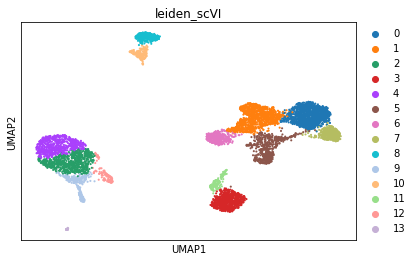

In [35]:
sc.pl.umap(adata, color=["leiden_scVI"])

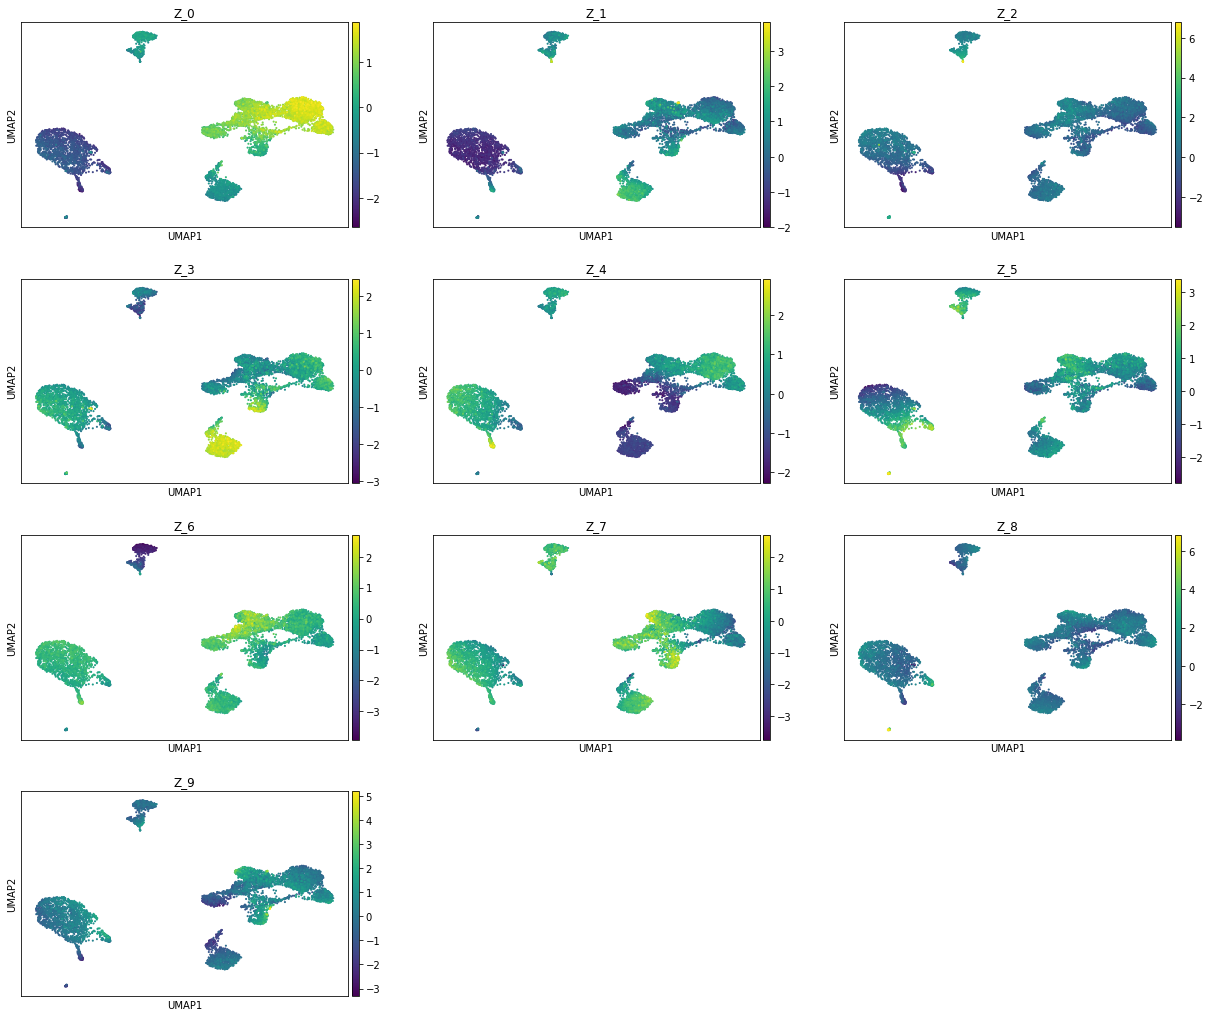

In [36]:
zs = [f'Z_{i}' for i in range(model.n_latent)]
sc.pl.umap(adata, color=zs, ncols=3)